# Model exploration, checking, and comparison

An important goal of creating pyei was to facilitate the exploration, evaluation, and comparison of models for ecological inference. We wanted to make it easier to perform the kinds of checks that are typically part of a Bayesian workflow, such as prior predictive checks, posterior predictive checks, diagnostics checks for the samples, etc. This notebooks is a work in progress, meant to demonstrate some ways to use pyei to better understand the underlying models.

In [1]:
import numpy as np
import pymc3 as pm
from matplotlib import pyplot as plt
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER, GoodmansERBayes
from pyei.data import Datasets

### Load some example data

In [2]:
# Load example data
data = Datasets.Santa_Clara.to_dataset()
X = np.array(data["pct_e_asian_vote"])
T = np.array(data["pct_for_hardy2"])
N = np.array(data["total2"])
demographic_group_name = "e_asian"
candidate_name="Hardy"
precinct_names = data['precinct']

### Set up the model

In [3]:
ei = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)

#NOTE: right now, the fit function is the easiest way to set the model (ei.sim_model), which we need for the prior predictive
# But, we of course don't use the draws from the posterior in the prior predictive checks!
# Note that the prior predictive draws of votes_count *DO* depend on precinct_pops and demographic_group_fractions
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names, draw_samples=False)


INFO (theano.gof.compilelock): Waiting for existing lock by process '83976' (I am process '14244')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/kknuds01/.theano/compiledir_macOS-10.15.5-x86_64-i386-64bit-i386-3.8.5-64/lock_dir


### Sample from the prior predictive distribution

In [4]:
# Sample from the prior predictive distributions
with ei.sim_model as sim_model:
    prior_pred = pm.sample_prior_predictive(10000)

In [5]:
### Examine the prior predictive distribution

In [6]:
# A list of the named random variables in the model (so that we know what we can examine)
pm.util.get_default_varnames(ei.sim_model.named_vars, include_transformed=False)

['phi_1', 'kappa_1', 'phi_2', 'kappa_2', 'b_1', 'b_2', 'votes_count']

In [7]:
prior_pred['votes_count'].shape # number of prior predictive draws x num_precincts

(10000, 42)

(array([1136., 1027.,  992.,  935.,  935.,  942.,  940.,  939., 1020.,
        1134.]),
 array([  0. ,  65.8, 131.6, 197.4, 263.2, 329. , 394.8, 460.6, 526.4,
        592.2, 658. ]),
 <a list of 10 Patch objects>)

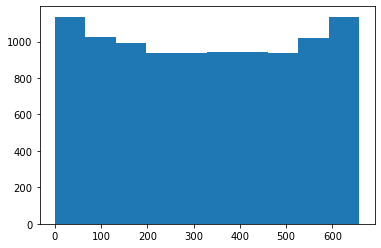

In [8]:
# plot a histogram of the prior predictive draws of the count of votes in the 0'th county
plt.hist(prior_pred['votes_count'][:,0])

(array([1298.,  923.,  939.,  935.,  914.,  890.,  943.,  910.,  958.,
        1290.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

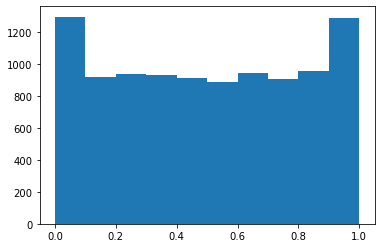

In [9]:
plt.hist(prior_pred['b_1'][:,0])

(array([1331.,  967.,  931.,  903.,  891.,  896.,  897.,  903.,  954.,
        1327.]),
 array([3.06387096e-286, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <a list of 10 Patch objects>)

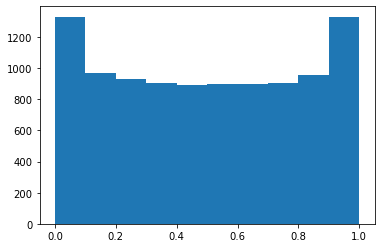

In [10]:
plt.hist(prior_pred['b_2'][:,0])

(array([9.991e+03, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([   8.00016356,  353.48698029,  698.97379702, 1044.46061374,
        1389.94743047, 1735.4342472 , 2080.92106393, 2426.40788065,
        2771.89469738, 3117.38151411, 3462.86833083]),
 <a list of 10 Patch objects>)

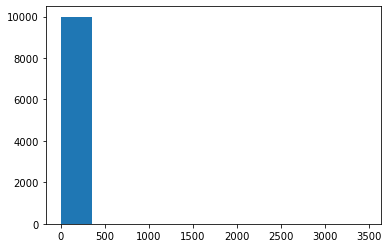

In [11]:
plt.hist(prior_pred['kappa_1'])

(array([1015.,  936., 1005., 1046., 1024.,  978., 1014., 1012.,  996.,
         974.]),
 array([4.93934853e-05, 1.00041666e-01, 2.00033939e-01, 3.00026212e-01,
        4.00018485e-01, 5.00010758e-01, 6.00003030e-01, 6.99995303e-01,
        7.99987576e-01, 8.99979849e-01, 9.99972122e-01]),
 <a list of 10 Patch objects>)

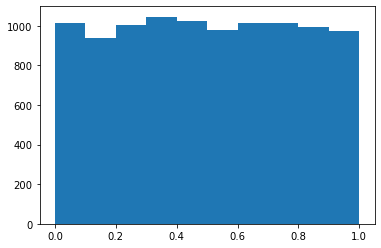

In [12]:
plt.hist(prior_pred['phi_1'])

In [13]:
# We can weight by population and obtain district-level voting preferences from the prior predictive samples, if we want
sampled_voting_prefs_gp1 = (prior_pred["b_1"] * N).sum(axis=1) / N.sum()
sampled_voting_prefs_gp2 = (prior_pred["b_2"] * N).sum(axis=1) / N.sum()


(array([1014.,  963., 1011., 1020., 1020.,  988.,  982., 1029.,  990.,
         983.]),
 array([3.56185854e-11, 9.99999974e-02, 1.99999995e-01, 2.99999992e-01,
        3.99999990e-01, 4.99999987e-01, 5.99999984e-01, 6.99999982e-01,
        7.99999979e-01, 8.99999977e-01, 9.99999974e-01]),
 <a list of 10 Patch objects>)

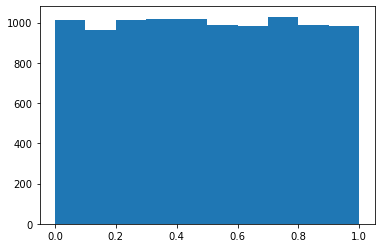

In [14]:
plt.hist(sampled_voting_prefs_gp1)

(array([ 214.,  619., 1011., 1362., 1766., 1779., 1374., 1014.,  622.,
         239.]),
 array([-0.99290263, -0.79458475, -0.59626687, -0.39794898, -0.1996311 ,
        -0.00131322,  0.19700466,  0.39532254,  0.59364042,  0.7919583 ,
         0.99027618]),
 <a list of 10 Patch objects>)

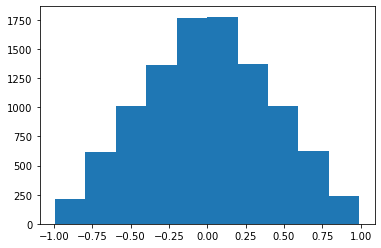

In [15]:
plt.hist(sampled_voting_prefs_gp1 - sampled_voting_prefs_gp2)

In [16]:
# We can probe, e.g., what percentage of samples from the prior predictive look polarized according to this measure
(abs(sampled_voting_prefs_gp1 - sampled_voting_prefs_gp2) > 0.1).sum()/ len(sampled_voting_prefs_gp1)

0.8117

### Fitting the model and generating posterior samples

In [17]:
## Fitting the model
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:44<00:00, 311.83draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Sample from the posterior predictive

In [18]:
with ei.sim_model as sim_model:
    posterior_pred = pm.sample_posterior_predictive(ei.sim_trace)

100%|██████████| 2000/2000 [00:01<00:00, 1438.27it/s]


(array([ 4.,  2., 10.,  9.,  5.,  3.,  4.,  2.,  1.,  2.]),
 array([ 95., 109., 123., 137., 151., 165., 179., 193., 207., 221., 235.]),
 <a list of 10 Patch objects>)

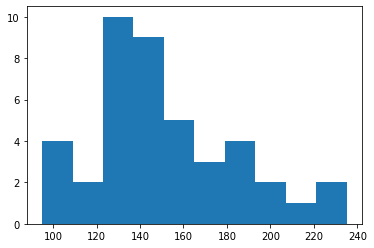

In [19]:
plt.hist(posterior_pred['votes_count'][0,:]) # Simulated vote counts for the 0th county

# Using arviz to explore the model:

Pyei works well with arviz, a library for exploratory analysis of bayesian models.


In [20]:
import arviz as az

### We'll use the outputs of pyei and pymc and will create a data inference object that has prior predictive, posterior, and posterior predictive distributions all contained within it. 

In [21]:
# with arviz
data = az.from_pymc3(
    trace=ei.sim_trace, #the posterior distribution
    prior=prior_pred,
    posterior_predictive=posterior_pred,
    model=ei.sim_model,
)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### We can look at some convergence diagnostics like rhat and the essential sample size for each variable

In [22]:
az.ess(data)

<xarray.Dataset>
Dimensions:    (b_1_dim_0: 42, b_2_dim_0: 42)
Coordinates:
  * b_1_dim_0  (b_1_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * b_2_dim_0  (b_2_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
Data variables:
    phi_1      float64 16.64
    kappa_1    float64 424.5
    phi_2      float64 23.84
    kappa_2    float64 523.9
    b_1        (b_1_dim_0) float64 38.64 33.45 32.16 33.99 ... 58.39 37.96 37.22
    b_2        (b_2_dim_0) float64 189.1 109.3 98.24 119.2 ... 84.6 111.4 99.77

In [23]:
az.rhat(data)

<xarray.Dataset>
Dimensions:    (b_1_dim_0: 42, b_2_dim_0: 42)
Coordinates:
  * b_1_dim_0  (b_1_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * b_2_dim_0  (b_2_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
Data variables:
    phi_1      float64 1.197
    kappa_1    float64 1.014
    phi_2      float64 1.141
    kappa_2    float64 1.007
    b_1        (b_1_dim_0) float64 1.079 1.09 1.094 1.085 ... 1.057 1.081 1.095
    b_2        (b_2_dim_0) float64 1.021 1.036 1.039 1.032 ... 1.044 1.033 1.035

### Traceplots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe47b942580>,
      dtype=object)

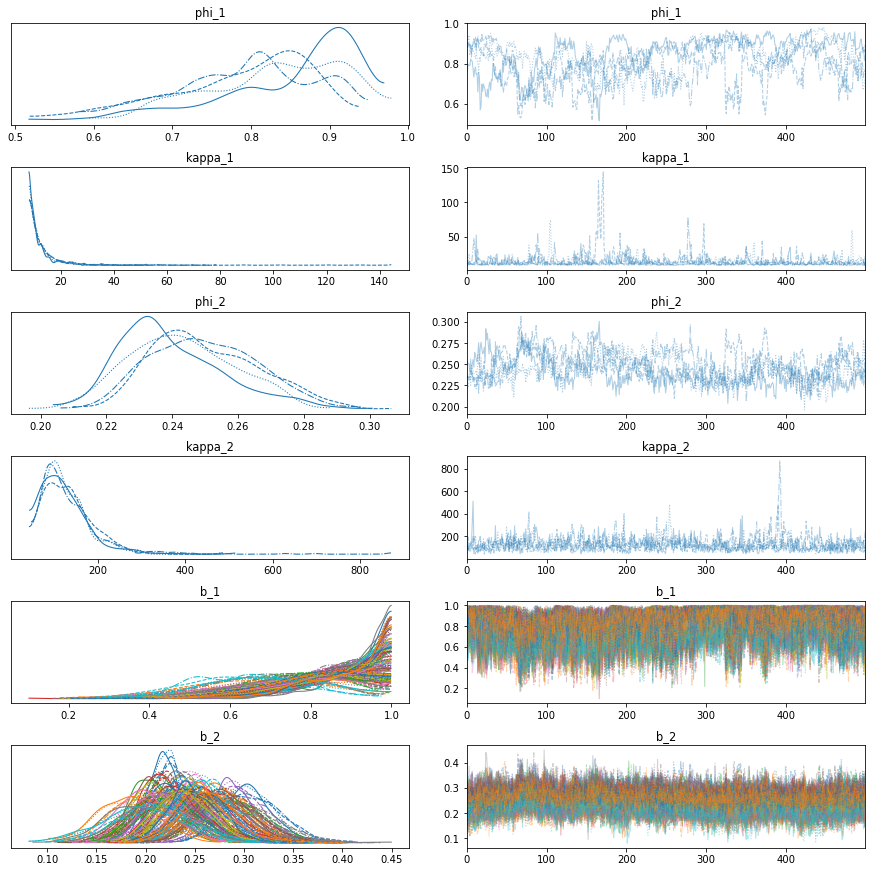

In [24]:
az.plot_trace(data, compact=True)
# each color here is a different chain, vertical tick marks mark divergences
# Set compact = False to see each county on a different plot

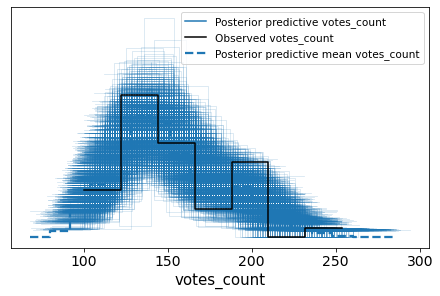

In [25]:
## We can look at posterior predictive draws
az.plot_ppc(data)

### We can compare prior and posterior distributions of variables of interest

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe47acf1280>,
      dtype=object)

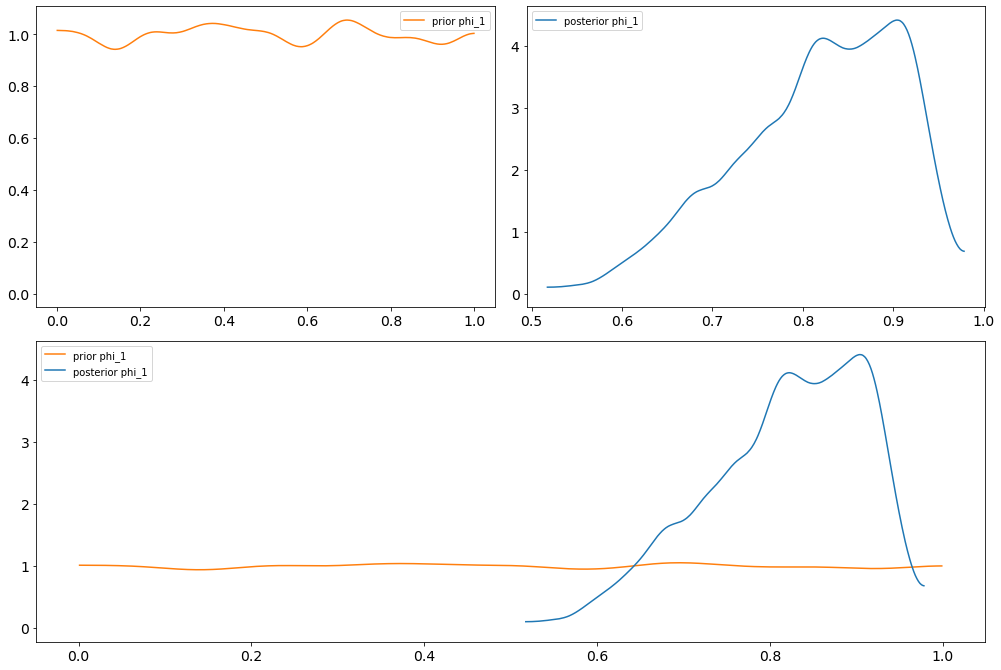

In [26]:
az.plot_dist_comparison(data, var_names='phi_1')

In [27]:
#az.plot_dist_comparison(data, var_names='b_2')

In [28]:
#data.posterior['voting_prefs_gp1'] =  ei.sampled_voting_prefs[0]

In [29]:
#data.posterior['voting_prefs_gp2'] =  ei.sampled_voting_prefs[1]

In [30]:
#az.plot_dist(data.posterior['voting_prefs_gp1'])

### Draws from the prior predictive distribution are one source of simulated data on which we can test our model


Note that the prior predictive distribution will use the precinct populations (here, N) and the group fractions (here X) in generating the vote counts for each county. Here we'll come up with fictional X and N before we use them to generate the votes.

This is a generous-to-the-model way to make fake data for our model -- since the data comes from the generative model itself! We also want to think about what happens if the data in the real world doesn't look much like data from the generative model.

In [109]:
num_precincts = 10
X = np.linspace(0.1, 0.9, num_precincts)
N = 100 * np.ones(num_precincts)
T = 50 * np.ones(num_precincts) / N #ei.fit needs a vote_counts, value, even though this won't get used in the prior predictive

In [110]:
# Sample from the prior predictive
ei.fit(X, T, N, draw_samples=False)
with ei.sim_model as model:
    prior_pred_for_simulation = pm.sample_prior_predictive()

In [111]:
# Use one of the prior predictive samples as simulated data
sample_num = 0
simulated_vote_fraction = prior_pred_for_simulation['votes_count'][sample_num,:] / N

In [112]:
ei.fit(X, simulated_vote_fraction, N)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]
Sampling 4 chains, 2 divergences: 100%|██████████| 8000/8000 [00:20<00:00, 382.64draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


(<matplotlib.axes._subplots.AxesSubplot at 0x7fe46f09e250>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe47cafb700>)

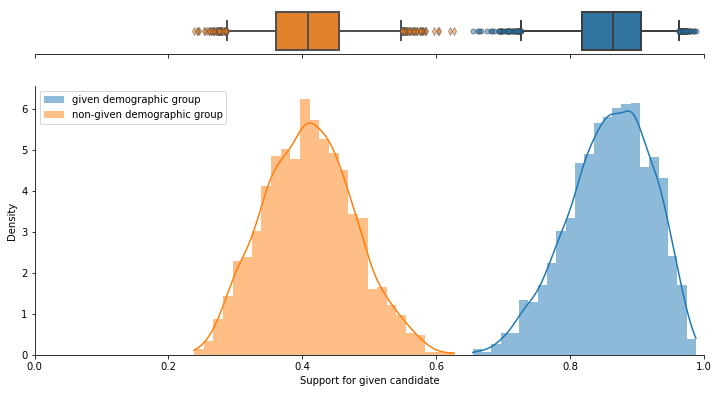

In [113]:
ei.plot()

In [114]:
# compute true district-level voting preferences
voting_pref_gp1 = (prior_pred_for_simulation['b_1'][sample_num,:] * N).sum() / N.sum()
voting_pref_gp2 = (prior_pred_for_simulation['b_2'][sample_num,:] * N).sum() / N.sum()

0.7722307063549765 0.48215453234999833


In [121]:
print(ei.summary())
print("true values:", voting_pref_gp1, voting_pref_gp2)

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        given demographic group for given candidate is
        0.859
        The posterior mean for the district-level voting preference of
        non-given demographic group for given candidate is
        0.410
        95% Bayesian credible interval for district-level voting preference of
        given demographic group for given candidate is
        [0.72624223 0.96221743]
        95% Bayesian credible interval for district-level voting preference of
        non-given demographic group for given candidate is
        [0.28808212 0.54797449]
        
true values: 0.7722307063549765 0.48215453234999833


In [116]:
# we can compare the inferred betas to the actual ones
prior_pred_for_simulation['b_1'][sample_num,:] #actual
b_1_posterior_means, b_2_posterior_means, b_1_credible_ints, b_2_credible_ints = ei.precinct_level_estimates() # inferred
b_1_int_lower = [x[0] for x in b_1_credible_ints]
b_1_int_upper = [x[1] for x in b_1_credible_ints]
b_2_int_lower = [x[0] for x in b_2_credible_ints]
b_2_int_upper = [x[1] for x in b_2_credible_ints]
import pandas as pd
df_b1 = pd.DataFrame({'actual': prior_pred_for_simulation['b_1'][sample_num,:], 'inferred': b_1_posterior_means, '95% CI lower':b_1_int_lower, '95% CI upper':b_1_int_upper})
df_b2 = pd.DataFrame({'actual': prior_pred_for_simulation['b_2'][sample_num,:], 'inferred': b_2_posterior_means, '95% CI lower':b_2_int_lower, '95% CI upper':b_2_int_upper})
df_b1

,actual,inferred,95% CI lower,95% CI upper
0,0.668259,0.859366,0.559682,0.996765
1,0.749752,0.861391,0.540942,0.998034
2,0.817219,0.845483,0.536483,0.998259
3,0.663963,0.844336,0.554881,0.997829
4,0.516194,0.799081,0.509859,0.992458
5,0.868108,0.805214,0.545295,0.994446
6,0.817176,0.895585,0.726223,0.997210
7,0.864647,0.885106,0.730876,0.995483
8,0.968724,0.952543,0.869070,0.999105
9,0.788264,0.839471,0.740874,0.926438


Text(0.5, 1.0, 'county level actual and estimate support of group 1 for candidate 1')

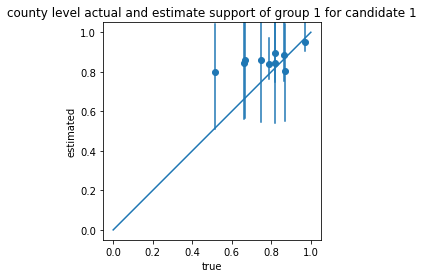

In [117]:
from matplotlib import pyplot as plt
plt.scatter(df_b1['actual'], df_b1['inferred'])
for true_val, cred_int in zip(df_b1['actual'], b_1_credible_ints):
    plt.axvline(x=true_val, ymin=cred_int[0], ymax=cred_int[1])
plt.plot((0,1), (0,1))
plt.axis('square')
plt.xlabel('true')
plt.ylabel('estimated')
plt.title("county level actual and estimate support of group 1 for candidate 1")

Text(0.5, 1.0, 'county level actual and estimate support of group 2 for candidate 2')

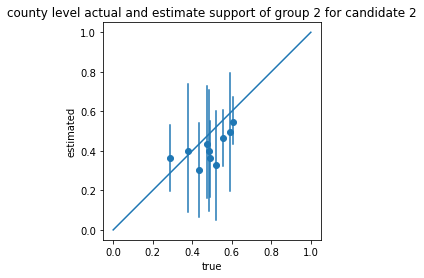

In [118]:
from matplotlib import pyplot as plt
plt.scatter(df_b2['actual'], df_b2['inferred'])
for true_val, cred_int in zip(df_b2['actual'], b_2_credible_ints):
    plt.axvline(x=true_val, ymin=cred_int[0], ymax=cred_int[1])
plt.plot((0,1), (0,1))
plt.axis('square')
plt.xlabel('true')
plt.ylabel('estimated')
plt.title("county level actual and estimate support of group 2 for candidate 2")

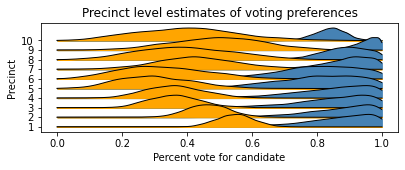

In [119]:
ei.precinct_level_plot()